# Amazon SageMaker with XGBoost and Hyperparameter Tuning for Credit Default predictions 
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Objective](#Objective)
1. [Background](#Background-(Problem-Description-and-Approach))
1. [Prepare our Environment](#Prepare-our-Environment)
1. [Download and Explore the Data](#Download-and-Explore-the-Data)
1. [Transform the Data](#Transform-the-Data)
1. [Understand the Algorithm](#Understand-the-Algorithm)
1. [Upload the Input Data to S3](#Upload-the-Input-Data-to-S3)
1. [Train the Model](#Train-the-Model)
1. [Deploy and Evaluate the Model](#Deploy-and-Evaluate-the-Model)
1. [Hyperparameter Optimization (HPO)](#Hyperparameter-Optimization-(HPO))
1. [Conclusions](#Conclusions)
1. [Releasing Cloud Resources](#Releasing-Cloud-Resources)


---

## Objective

This workshop aims to give you an **example of using and tuning a SageMaker built-in algorithm**: Focussing on the **data interfaces** and SageMaker's automatic **Hyperparameter Optimization** (HPO) capabilities.

Teaching in-depth data science approaches for tabular data is outside this scope, and we hope you can use this notebook as a starting point to modify for the needs of your future projects.

---

## Background (Problem Description and Approach)

- **Credit Default**: determining customers with probability to default on credit payments. 
- **Challenge**: A) too many potential customers. B) limited resources of the approacher (time, money etc.).
- **Problem: Which are the potential customers with the higher chance of becoming actual customers**? (so as to focus the effort only on them). 
- **Our setting**: A bank who wants to predict *whether a customer will enroll for a term deposit, after one or more phone calls*.
- **Our approach**: Build a ML model to do this prediction, from readily available information e.g. demographics, past interactions etc. (features).
- **Our tools**: We will be using the **XGBoost** algorithm implementation by **Amazon SageMaker**, and using SageMaker **Hyperparameter Optimization (HPO)** to improve our model.


---

## Prepare our Environment

We'll need to:

- **import** some useful libraries (as in any Python notebook)
- **configure** the S3 bucket and folder where data should be stored (to keep our environment tidy)
- **connect** to AWS in general (with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

While `boto3` is the general AWS SDK for Python, `sagemaker` provides some powerful, higher-level interfaces designed specifically for ML workflows.


In [1]:
!pip install matplotlib

In [2]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import time
import os
import util  # helper function for classification reports

# setting up SageMaker parameters
import sagemaker
import boto3

boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "xgboost-example"  # Location in the bucket to store our files
sgmk_session = sagemaker.Session()
sgmk_client = boto_session.client("sagemaker")
sgmk_role = sagemaker.get_execution_role()

print(sgmk_role)


arn:aws:iam::198302828498:role/DataScience/mod-b7ff6241936641a0-DemoPr-SageMakerExecutionRole-1NTMZQXVVYORP


---

## Download and Explore the Data

Let's start by accessing the output of our Data Wrangler process.
We can run shell commands from inside Jupyter using the `!` prefix:


In [3]:
flow_output_s3uri = "s3://creditmodel-demouser-mlrawdata-198302828498-us-east-1/taiwan.csv"
print(flow_output_s3uri)
!aws s3 ls $flow_output_s3uri

s3://creditmodel-demouser-mlrawdata-198302828498-us-east-1/taiwan.csv
2021-03-31 13:39:49    2867208 taiwan.csv


Now lets read this into a Pandas data frame and take a look.


In [8]:
df = util.data.dataframe_from_s3_folder(flow_output_s3uri)
df.head()

Loading taiwan.csv


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


---

## Understand the Algorithm

We'll be using SageMaker's [built-in **XGBoost Algorithm**](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html): Benefiting from performance-optimized, pre-implemented functionality like multi-instance parallelization, and support for multiple input formats.

In general to use the pre-built algorithms, we'll need to:

- Refer to the [Common Parameters docs](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) to see the **high-level configuration** and what features each algorithm has
- Refer to the [algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) to understand the **detail** of the **data formats** and **(hyper)-parameters** it supports

From these docs, we'll understand what data format we need to upload to S3 (next), and how to get the container image URI of the algorithm... which is listed on the Common Parameters page but can also be extracted through the SDK:


In [16]:
# specify container
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.0-1")

print(training_image)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


---

## Upload the Input Data to S3

We know from [the algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) that SageMaker XGBoost expects data in the **libSVM** or **CSV** formats, with:

- The target variable in the first column, and
- No header row

...So before initializing training, we will:

1. Suffle and split the data into **Training (70%)**, **Validation (20%)**, and **Test (10%)** sets
2. Save the data in the format the algorithm expects (e.g. CSV)
3. Upload the data to S3
4. Define the training job input "channels" with explicit CSV content type tagging, via the SageMaker SDK [TrainingInput](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class

The Training and Validation datasets will be used during the training (and tuning) phase, while the 'holdout' Test set will be used afterwards to evaluate the model.


In [25]:
# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(
    df.sample(frac=1, random_state=1729), 
    [int(0.7 * len(df)), int(0.9*len(df))],
) 

# Create CSV files for Train / Validation / Test
train_data.to_csv("data/train.csv", index=False, header=False)
validation_data.to_csv("data/validation.csv", index=False, header=False)
test_data.to_csv("data/test.csv", index=False, header=False)


In [26]:
# Upload CSV files to S3 for SageMaker training
train_uri = sgmk_session.upload_data(
    path="data/train.csv",
    bucket=bucket_name,
    key_prefix=bucket_prefix,
)
val_uri = sgmk_session.upload_data(
    path="data/validation.csv",
    bucket=bucket_name,
    key_prefix=bucket_prefix,
)


# Define the data input channels for the training job:
s3_input_train = sagemaker.inputs.TrainingInput(train_uri, content_type="csv")
s3_input_validation = sagemaker.inputs.TrainingInput(val_uri, content_type="csv")

print(f"{s3_input_train.config}\n\n{s3_input_validation.config}")

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-198302828498/xgboost-example/train.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-198302828498/xgboost-example/validation.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}


---

## Train the Model

Training a model on SageMaker follows the usual steps with other ML libraries (e.g. SciKit-Learn):
1. Initiate a session (we did this up top).
2. Instantiate an estimator object for our algorithm (XGBoost).
3. Define its hyperparameters.
4. Start the training job.


#### A small competition!
SageMaker's XGBoost includes 38 parameters. You can find more information about them [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).
For simplicity, we choose to experiment only with a few of them.


...and finally, actually create the training job using the high-level [Estimator API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

The `Estimator` class provides a familiar, scikit-learn-like API for `fit()`ting models to data, `deploy()`ing models to real-time endpoints, or running batch inference jobs.


In [27]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,      # XGBoost algorithm container
    instance_type="ml.m5.xlarge",  # type of training instance
    instance_count=1,              # number of instances to be used
    role=sgmk_role,                # IAM role to be used
    max_run=20*60,                 # Maximum allowed active runtime
    use_spot_instances=True,       # Use spot instances to reduce cost
    max_wait=30*60,                # Maximum clock time (including spot delays)
)

# scale_pos_weight is a paramater that controls the relative weights of the classes.
# Because the data set is so highly skewed, we set this parameter according to the ratio (n/y)
scale_pos_weight = np.count_nonzero(train_data["y"].values==0) / np.count_nonzero(train_data["y"].values)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150,     # int: [1,300]
    max_depth=5,     # int: [1,10]
    alpha=2,         # float: [0,5]
    eta=0.5,           # float: [0,1]
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,  # set the balance between the 2 classes
)

# start a training (fitting) job
estimator.fit({ "train": s3_input_train, "validation": s3_input_validation })


2021-03-31 15:45:37 Starting - Starting the training job...
2021-03-31 15:46:02 Starting - Launching requested ML instancesProfilerReport-1617205537: InProgress
.........
2021-03-31 15:47:22 Starting - Preparing the instances for training...
2021-03-31 15:48:03 Downloading - Downloading input data...
2021-03-31 15:48:39 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[15:48:42] 21000x23 matrix with 483000 entries loaded from /opt/ml/input/data/train?format

---

## Deploy and Evaluate the Model

### Deployment

Now that we've trained the xgboost algorithm on our data, deploying the model (hosting it behind a real-time endpoint) is just one function call!

This deployment might take **up to 10 minutes**, and by default the code will wait for the deployment to complete.

If you like, you can instead:

- Un-comment the `wait=False` parameter
- Use the [Endpoints page of the SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/endpoints) to check the status of the deployment
- Skip over the *Evaluation* section below (which won't run until the deployment is complete), and start the Hyperparameter Optimization job - which will take a while to run too, so can be started in parallel


In [28]:
# Real-time endpoint:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    # wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
)


-------------!

### Evaluation

Since SageMaker is a general purpose ML platform and our endpoint is a web service, we'll need to be explicit that we're sending in tabular data (_serialized_ in CSV string format for the HTTPS request) and expect a tabular response (to be _deserialized_ from CSV to numpy).

In the SageMaker SDK (from v2), this packing and unpacking of the payload for the web endpoint is handled by [serializer classes](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializer classes](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html).

Unfortunately the pre-built `CSVDeserializer` produces nested Python lists of strings, rather than a numpy array of numbers - so rather than bothering to implement a custom class (like the examples [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/deserializers.py)) we'll be lazy and take this as a post-processing step.

With this setup ready, requesting inferences is as easy as calling `predictor.predict()`:

In [29]:
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

In [30]:
X_test_numpy = test_data.drop(["y"], axis=1).values

predictions = np.array(predictor.predict(X_test_numpy), dtype=float).squeeze()
predictions

array([0.46124288, 0.38137776, 0.25482357, ..., 0.78285301, 0.03504252,
       0.43115321])

Each number in this vector is the **predicted probability** (in the interval [0,1]) of a potential customer enrolling for a term deposit.

- 0: The person **will not** default
- 1: The person **will** default

If we like, we could stitch these predictions back on to the original dataframe to explore performance:


In [31]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_data.index),
        test_data,
    ],
    axis=1
)
test_results.head()


,y_pred,y,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
21001,0.461243,1,280000,1,3,1,40,2,0,0,...,188411,191291,189029,192023,10000,9000,8000,6738,6974,7600
25401,0.381378,0,90000,2,1,2,24,0,0,0,...,62725,57716,43970,36415,2366,4000,3000,2000,3480,15000
14066,0.254824,0,140000,1,2,2,39,1,2,2,...,143084,142011,136431,128118,7000,0,6000,5200,5000,5000
25301,0.238271,0,80000,2,3,2,25,0,0,0,...,84871,81813,45094,38121,3200,4000,3000,1500,1500,1300
25447,0.154126,0,240000,2,1,2,27,0,0,-2,...,0,0,0,0,0,0,0,0,0,0


...Or use this function we provided to generate a more **comprehensive model report**:


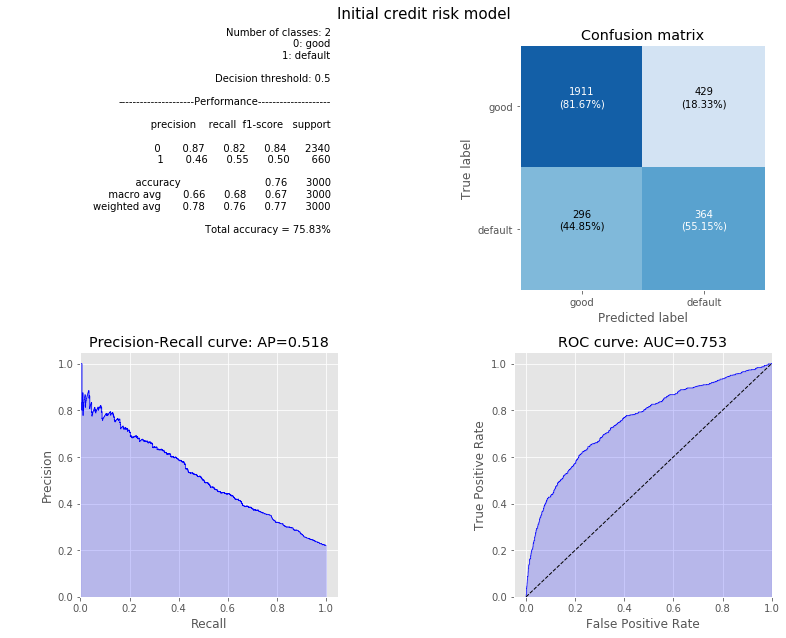

In [34]:
util.plotting.generate_classification_report(
    y_real=test_results["y"],
    y_predict_proba=test_results["y_pred"],
    decision_threshold=0.5,
    class_names_list=["good", "default"],
    title="Initial credit risk model",
)


---

## Hyperparameter Optimization (HPO)
*Note, with the default settings below, the hyperparameter tuning job can take up to ~20 minutes to complete.*

We will use SageMaker HyperParameter Optimization (HPO) to automate the searching process effectively. Specifically, we **specify a range**, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune.

SageMaker hyperparameter tuning will automatically launch **multiple training jobs** with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will specify the maximum number of HPO tries (`max_jobs`) and how many of these can happen in parallel (`max_parallel_jobs`).

Tip: `max_parallel_jobs` creates a **trade-off between performance and speed** (better hyperparameter values vs how long it takes to find these values). If `max_parallel_jobs` is large, then HPO is faster, but the discovered values may not be optimal. Smaller `max_parallel_jobs` will increase the chance of finding optimal values, but HPO will take more time to finish.

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: **validation:auc** and **train:auc**, and we elected to monitor *validation:auc* as you can see below. In this case (because it's pre-built for us), we only need to specify the metric name.

For more information on the documentation of the Sagemaker HPO please refer [here](https://sagemaker.readthedocs.io/en/stable/tuner.html).

In [ ]:
# import required HPO objects
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# set up hyperparameter ranges
ranges = {
    "num_round": IntegerParameter(1, 300),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,              # the SageMaker estimator object
    hyperparameter_ranges=ranges,     # the range of hyperparameters
    max_jobs=20,                      # total number of HPO jobs
    max_parallel_jobs=4,              # how many HPO jobs can run in parallel
    strategy="Bayesian",              # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",        # maximize or minimize the objective metric
)  


### Launch HPO
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [ ]:
# start HPO
tuner.fit({ "train": s3_input_train, "validation": s3_input_validation })


HPO jobs often take quite a long time to finish and as such, sometimes you may want to free up the notebook and then resume the wait later.

Just like the Estimator, we won't be able to `deploy()` the model until the HPO tuning job is complete; and the status is visible through both the [AWS Console](https://console.aws.amazon.com/sagemaker/home?#/hyper-tuning-jobs) and the [SageMaker API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html). We could for example write a polling script like the below:

### Deploy and test optimized model
Deploying the best model is another simple `.deploy()` call:

In [ ]:
# deploy the best model from HPO
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)


Once deployed, we can now evaluate the performance of the best model.

In [ ]:
# getting the predicted probabilities of the best model
hpo_predictions = np.array(hpo_predictor.predict(X_test_numpy), dtype=float).squeeze()
print(hpo_predictions)

# generate report for the best model
generate_classification_report(
    y_actual=test_data["y"].values, 
    y_predict_proba=hpo_predictions, 
    decision_threshold=0.5,
    class_names_list=["Did not enroll","Enrolled"],
    model_info="Best model (with HPO)",
)


---

## Conclusions

In our run, the optimized HPO model exhibited an AUC of ~0.774: fairly higher than our first-guess parameter combination!

Depending on the number of tries, HPO can find a better performing model faster, compared to simply trying different hyperparameters by trial and error or grid search. You can learn more in-depth details about SageMaker HPO [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

SageMaker built-in algorithms are great for getting a first model fast, and combining them with SageMaker HPO can really boost their accuracy.

As we mentioned here, the best way to success with a built-in algorithm is to **read the [algorithm's doc pages](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) carefully** - to understand what data format and parameters it needs!


---

## Releasing Cloud Resources

It's generally a good practice to deactivate all endpoints which are not in use.  

Please uncomment the following lines and run the cell in order to deactivate the 2 endpoints that were created before. 


In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)
hpo_predictor.delete_endpoint(delete_endpoint_config=True)
